In [2]:
import sys
sys.path.append('../berry')
import berrylib.util as util
util.setup_nb()

In [3]:
from scipy.special import logit, expit
import scipy.special
import matplotlib.pyplot as plt
import numpy as np
import pykevlar.grid as grid
import berrylib.fast_inla as fast_inla
import berrylib.binomial as binomial

/Users/tbent/.mambaforge/envs/kevlar/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


In [3]:
fi = fast_inla.FastINLA(2)

name = 'berry2d'
n_arms = 2
n_arm_samples = 35
seed = 10
n_theta_1d = 16
sim_size = 10000

# define null hypos
null_hypos = []
for i in range(n_arms):
    n = np.zeros(n_arms)
    # null is:
    # theta_i <= logit(0.1)
    # the normal should point towards the negative direction. but that also
    # means we need to negate the logit(0.1) offset
    n[i] = -1
    null_hypos.append(grid.HyperPlane(n, -logit(0.1)))

gr = grid.make_cartesian_grid_range(n_theta_1d, np.full(n_arms, -3.5), np.full(n_arms, 1.0), sim_size)
gr.create_tiles(null_hypos)
gr.prune()

In [4]:
theta = gr.thetas().T
theta_tiles = grid.theta_tiles(gr)
is_null_per_arm = grid.is_null_per_arm(gr)

In [5]:
%%time
samples = np.random.uniform(size=(sim_size, n_arm_samples, n_arms))
accumulator = binomial.binomial_accumulator(fi.rejection_inference)
typeI_sum, typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)

CPU times: user 9.65 s, sys: 536 ms, total: 10.2 s
Wall time: 3.57 s


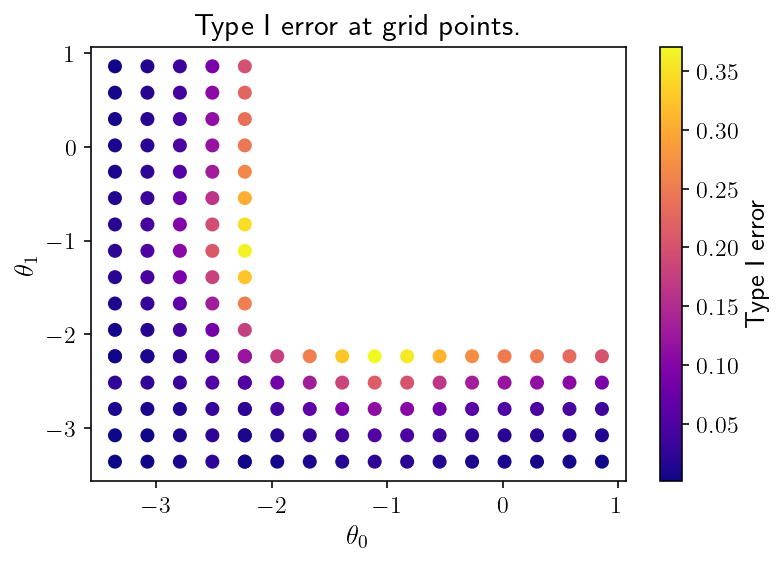

In [6]:
plt.figure()
plt.title('Type I error at grid points.')
plt.scatter(theta_tiles[:,0], theta_tiles[:,1], c=typeI_sum / sim_size)
cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()

In [10]:
%%time
opt_sim_size = 1000
def compute_bound_gradient(typeI_sum, typeI_score):
    delta_prop_0to1 = 0.5
    delta = 0.025
    d0u_factor = 1.0 - delta * delta_prop_0to1
    delta_0_j = typeI_sum / opt_sim_size
    delta_0_u_j = scipy.special.betaincinv(
        typeI_sum + 1,
        opt_sim_size - typeI_sum,
        d0u_factor
    ) - delta_0_j
    gradient = typeI_score / opt_sim_size
    return delta_0_j + delta_0_u_j, gradient 

def obj_gradient(ts):
    samples = np.random.uniform(size=(opt_sim_size, n_arm_samples, n_arms))
    is_null = ts < logit(0.1)
    t1sum, t1score = accumulator(ts[None], is_null[None], samples)
    t1sum = t1sum[0].to_py()
    t1score = t1score[0].to_py()
    bound, gradient = compute_bound_gradient(t1sum, t1score)
    return bound, gradient

def optimize_typeI(t0):
    theta_cur = t0
    is_null_cur = theta_cur < logit(0.1)
    def set_theta(ts):
        nulls = ts < logit(0.1)
        # Check bounds and project to null hypo space if needed
        if np.all(~nulls):
            old_null_idxs = np.where(is_null_cur)[0]
            ts[old_null_idxs] = logit(0.1) - 1e-7
        theta_cur[:] = ts
        is_null_cur[:] = theta_cur < logit(0.1)
    lr = 0.5
        
    path = []
    for i in range(200):
        bound, gradient = obj_gradient(theta_cur)
        path.append(theta_cur.copy())
        step = gradient * lr
        # print('')
        # print('state:', theta_cur, t1sum / sim_size, bound, gradient)
        # print('step:', step)
        set_theta(theta_cur + step) 
    return np.array(path)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 5.72 µs


In [11]:
# import scipy.optimize


# def optimize_typeI(t0):
#     path = []

#     def obj_gradient(ts):
#         samples = np.random.uniform(size=(sim_size, n_arm_samples, n_arms))
#         is_null = ts < logit(0.1)
#         t1sum, t1score = accumulator(ts[None], is_null[None], samples)
#         t1sum = t1sum[0].to_py()
#         t1score = t1score[0].to_py()
#         bound, gradient = compute_bound_gradient(t1sum, t1score)
#         path.append(ts.copy())
#         return bound, gradient

#     constraints = [
#         scipy.optimize.LinearConstraint(
#             [[1, 0], [0, 1]], [-np.inf, -np.inf], [logit(0.1), logit(0.1)]
#         )
#     ]
#     opt = scipy.optimize.minimize(
#         lambda x: -obj(x)[0],
#         t0,
#         method="COBYLA",
#         jac=lambda x: -obj(x)[1],
#         constraints=constraints,
#     )
#     path = np.array(path)
#     return path


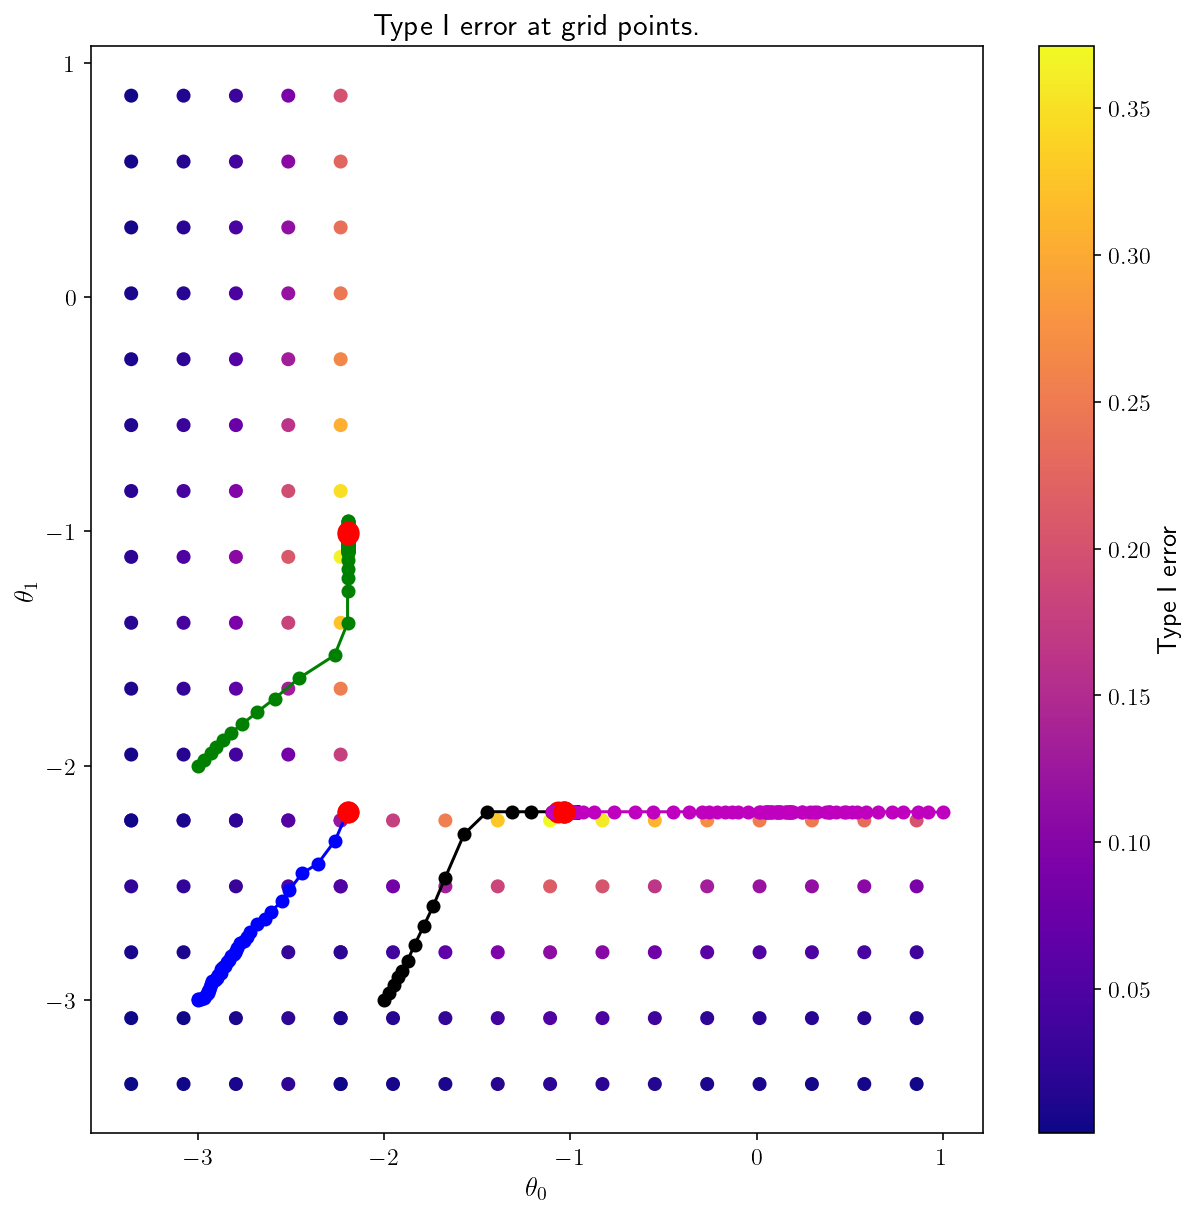

In [13]:
from matplotlib import cm
plt.figure(figsize=(10,10))
plt.title("Type I error at grid points.")
plt.scatter(theta_tiles[:, 0], theta_tiles[:, 1], c=typeI_sum / sim_size)
for i, t0 in enumerate([
    np.array([-2.0, -3.0]),
    np.array([-3.0, -2.0]),
    np.array([-3.0, -3.0]),
    np.array([1.0, -2.2]),
]):
    path = optimize_typeI(t0)
    # color = cm.hot(np.arange(path.shape[0],dtype=np.float64) / path.shape[0])
    # plt.scatter(path[:, 0], path[:, 1], c=color, edgecolor='none')
    color = ['k', 'g', 'b', 'm'][i]
    plt.plot(path[:, 0], path[:, 1], color + "-o")
    plt.plot(path[-2:, 0], path[-2:, 1], "ro", markersize=10)

cbar = plt.colorbar()
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$")
cbar.set_label("Type I error")
plt.show()


## 4D version

In [4]:
fi = fast_inla.FastINLA(4)

name = 'berry4d'
n_arms = 4
n_arm_samples = 35
seed = 10
n_theta_1d = 10
sim_size = 4000

# define null hypos
null_hypos = []
for i in range(n_arms):
    n = np.zeros(n_arms)
    # null is:
    # theta_i <= logit(0.1)
    # the normal should point towards the negative direction. but that also
    # means we need to negate the logit(0.1) offset
    n[i] = -1
    null_hypos.append(grid.HyperPlane(n, -logit(0.1)))

gr = grid.make_cartesian_grid_range(n_theta_1d, np.full(n_arms, -3.5), np.full(n_arms, 1.0), sim_size)
gr.create_tiles(null_hypos)
gr.prune()

In [5]:
theta = gr.thetas().T
theta_tiles = grid.theta_tiles(gr)
is_null_per_arm = grid.is_null_per_arm(gr)

In [6]:
%%time
table = binomial.build_rejection_table(fi.n_arms, n_arm_samples, fi.rejection_inference)

CPU times: user 4.29 s, sys: 253 ms, total: 4.54 s
Wall time: 3.33 s


In [7]:
%%time
samples = np.random.uniform(size=(sim_size, n_arm_samples, n_arms))
reject_fnc = lambda y, n: binomial.lookup_rejection(table, y, n)
accumulator = binomial.binomial_accumulator(reject_fnc)
typeI_sum, typeI_score = accumulator(theta_tiles, is_null_per_arm, samples)

CPU times: user 5.2 s, sys: 17.2 s, total: 22.4 s
Wall time: 11.1 s


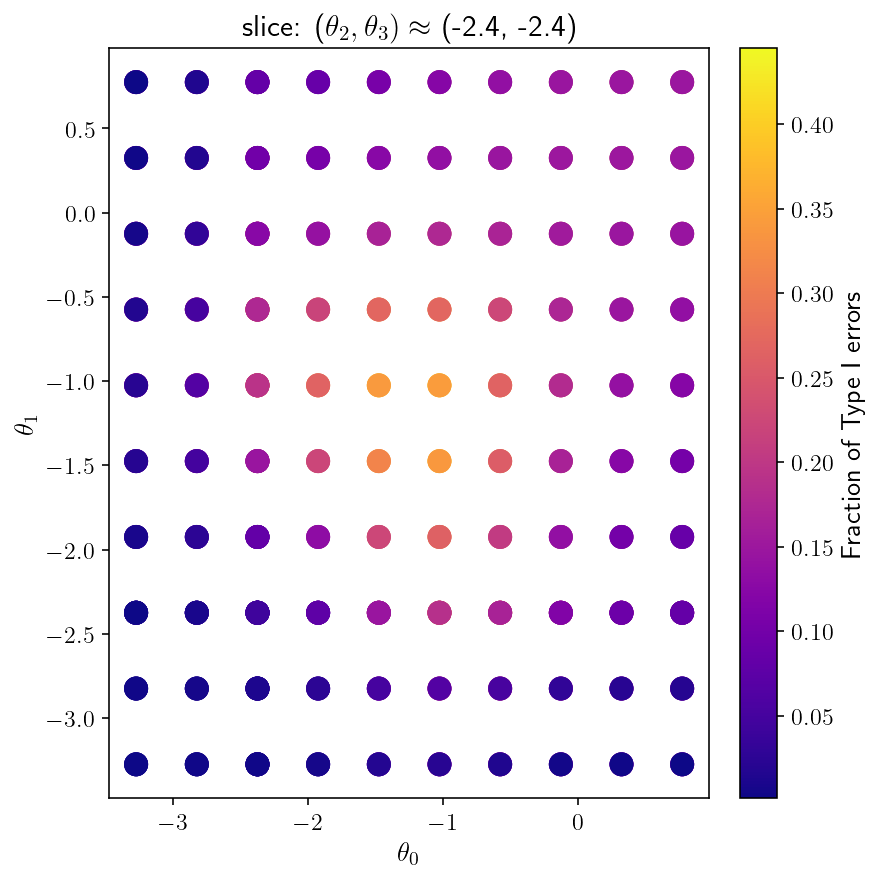

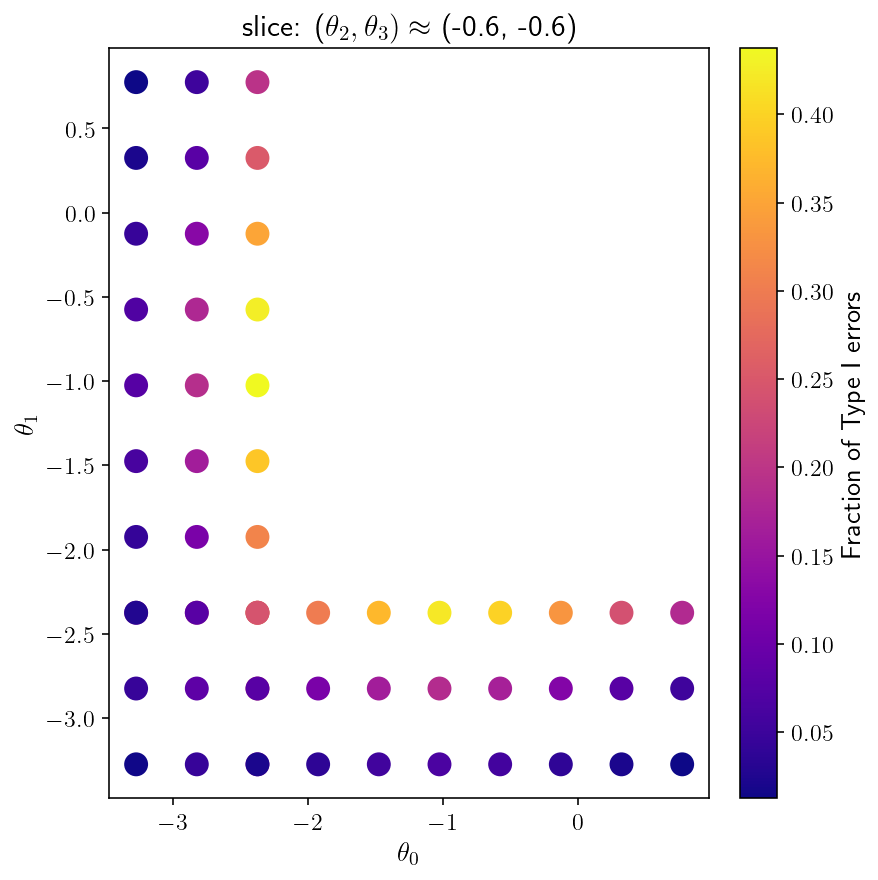

In [8]:
for t2_idx, t3_idx in [(2, 2), (6, 6)]:
    t2 = np.unique(theta_tiles[:, 2])[t2_idx]
    t3 = np.unique(theta_tiles[:, 2])[t3_idx]
    selection = (theta_tiles[:,2] == t2) & (theta_tiles[:,3] == t3)

    plt.figure(figsize=(6,6), constrained_layout=True)
    plt.title(f'slice: ($\\theta_2, \\theta_3) \\approx$ ({t2:.1f}, {t3:.1f})')
    plt.scatter(theta_tiles[selection,0], theta_tiles[selection,1], c=typeI_sum[selection]/sim_size, s=120)
    cbar = plt.colorbar()
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    cbar.set_label('Fraction of Type I errors')
    plt.show()

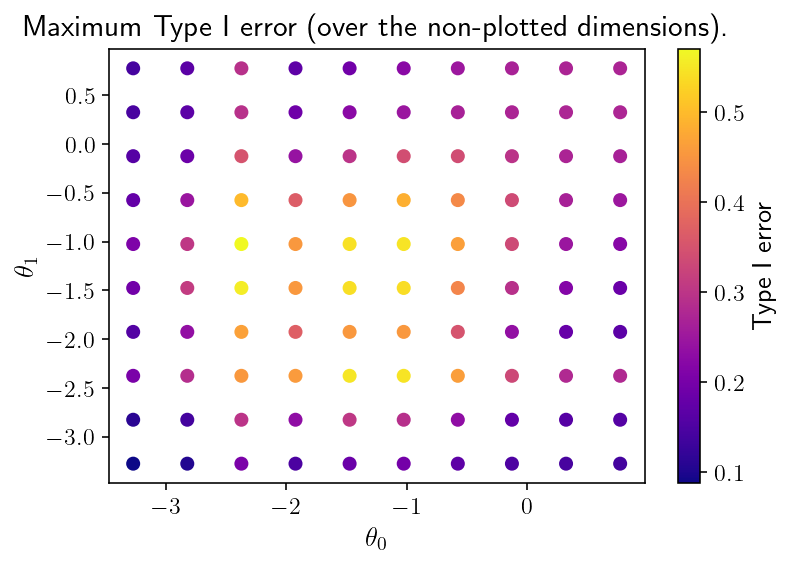

In [9]:
uniques, unique_sets = np.unique(theta_tiles[:, :2], axis=0, return_inverse=True)
unique_max = np.empty(uniques.shape[0])
for i in range(uniques.shape[0]):
    unique_max[i] = typeI_sum[unique_sets == i].max()
plt.figure()
plt.title('Maximum Type I error (over the non-plotted dimensions).')
plt.scatter(uniques[:,0], uniques[:,1], c=unique_max / sim_size)
cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()

In [10]:
%%time
opt_sim_size = 1000
def compute_bound_gradient(typeI_sum, typeI_score):
    delta_prop_0to1 = 0.5
    delta = 0.025
    d0u_factor = 1.0 - delta * delta_prop_0to1
    delta_0_j = typeI_sum / opt_sim_size
    delta_0_u_j = scipy.special.betaincinv(
        typeI_sum + 1,
        opt_sim_size - typeI_sum,
        d0u_factor
    ) - delta_0_j
    gradient = typeI_score / opt_sim_size
    return delta_0_j + delta_0_u_j, gradient 

def obj_gradient(ts):
    samples = np.random.uniform(size=(opt_sim_size, n_arm_samples, n_arms))
    is_null = ts < logit(0.1)
    t1sum, t1score = accumulator(ts[None], is_null[None], samples)
    t1sum = t1sum[0].to_py()
    t1score = t1score[0].to_py()
    bound, gradient = compute_bound_gradient(t1sum, t1score)
    return bound, gradient

def optimize_typeI(t0):
    theta_cur = t0
    is_null_cur = theta_cur < logit(0.1)
    def set_theta(ts):
        nulls = ts < logit(0.1)
        # Check bounds and project to null hypo space if needed
        if np.all(~nulls):
            old_null_idxs = np.where(is_null_cur)[0]
            ts[old_null_idxs] = logit(0.1) - 1e-7
        theta_cur[:] = ts
        is_null_cur[:] = theta_cur < logit(0.1)
    lr = 0.5
        
    path = []
    for i in range(200):
        bound, gradient = obj_gradient(theta_cur)
        path.append(theta_cur.copy())
        step = gradient * lr
        # print('')
        # print('state:', theta_cur, t1sum / sim_size, bound, gradient)
        # print('step:', step)
        set_theta(theta_cur + step) 
    return np.array(path)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 5.01 µs


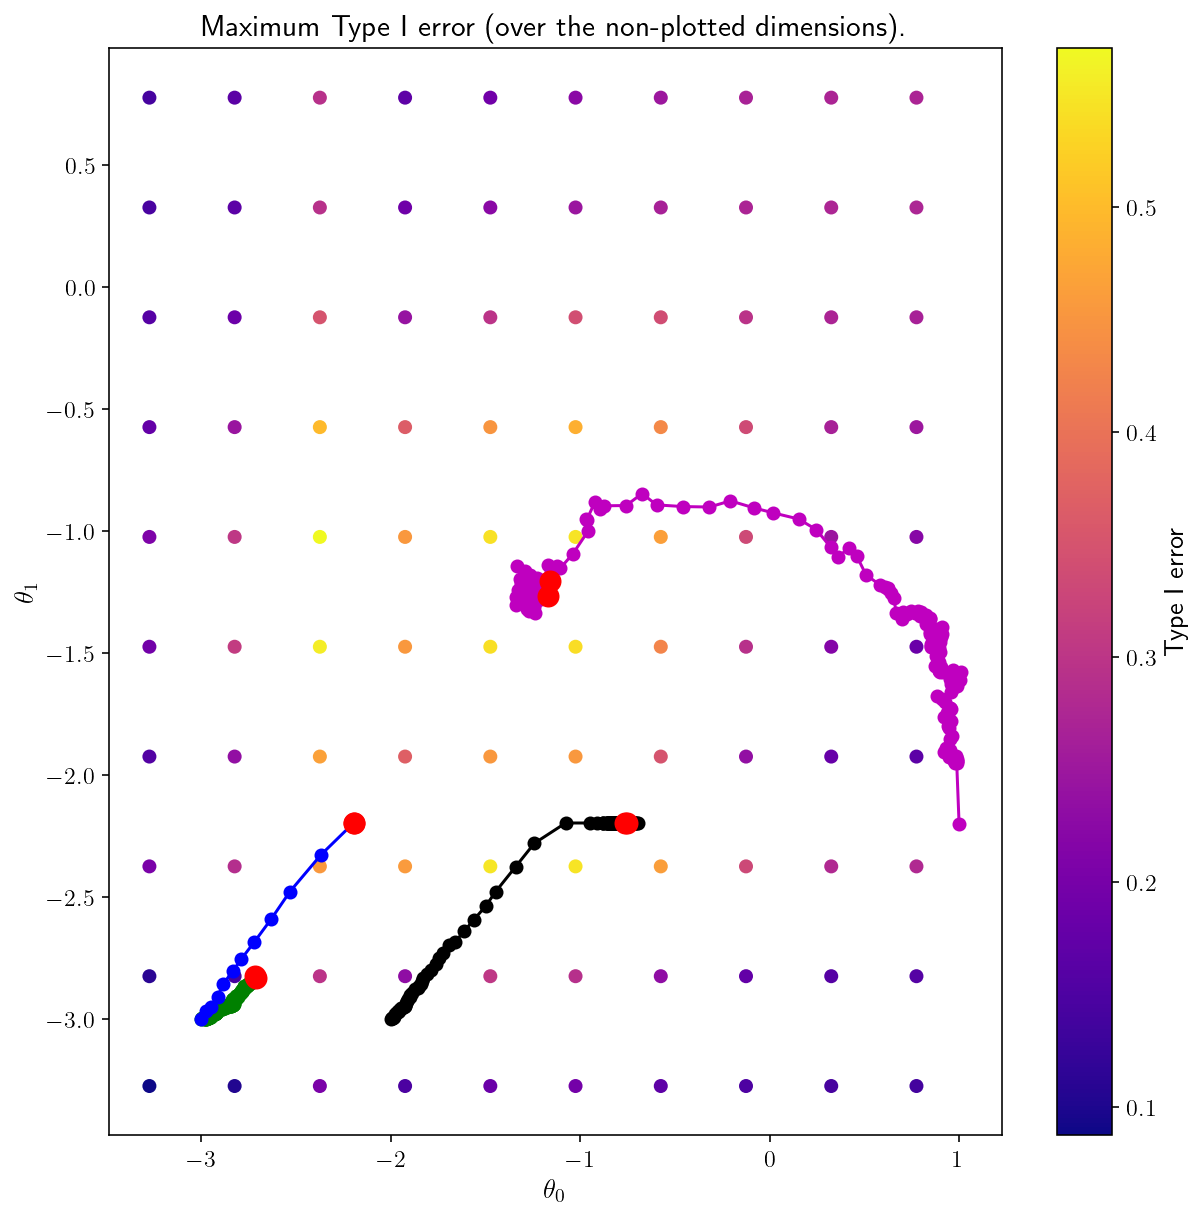

In [11]:
from matplotlib import cm
plt.figure(figsize=(10,10))
plt.title("Type I error at grid points.")
plt.title('Maximum Type I error (over the non-plotted dimensions).')
plt.scatter(uniques[:,0], uniques[:,1], c=unique_max / sim_size)
for i, t0 in enumerate([
    np.array([-2.0, -3.0, -3.0, -3.0]),
    np.array([-3.0, -3.0, -3.0, -3.0]),
    np.array([-3.0, -3.0, 0.0, 0.0]),
    np.array([1.0, -2.2, -3.0, 0.0]),
]):
    path = optimize_typeI(t0)
    # color = cm.hot(np.arange(path.shape[0],dtype=np.float64) / path.shape[0])
    # plt.scatter(path[:, 0], path[:, 1], c=color, edgecolor='none')
    color = ['k', 'g', 'b', 'm'][i]
    plt.plot(path[:, 0], path[:, 1], color + "-o")
    plt.plot(path[-2:, 0], path[-2:, 1], "ro", markersize=10)

cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()


In [22]:
paths=[]
for i in range(100):
    t0 = -3 + np.random.uniform(size=(4)) * 4
    if np.all(t0 > logit(0.1)):
        continue
    paths.append(optimize_typeI(t0))

In [23]:
paths = np.array(paths)

In [26]:
paths.shape

(60, 200, 4)

In [29]:
(8 ** 4 * 200) ** 0.25

30.084824744691147

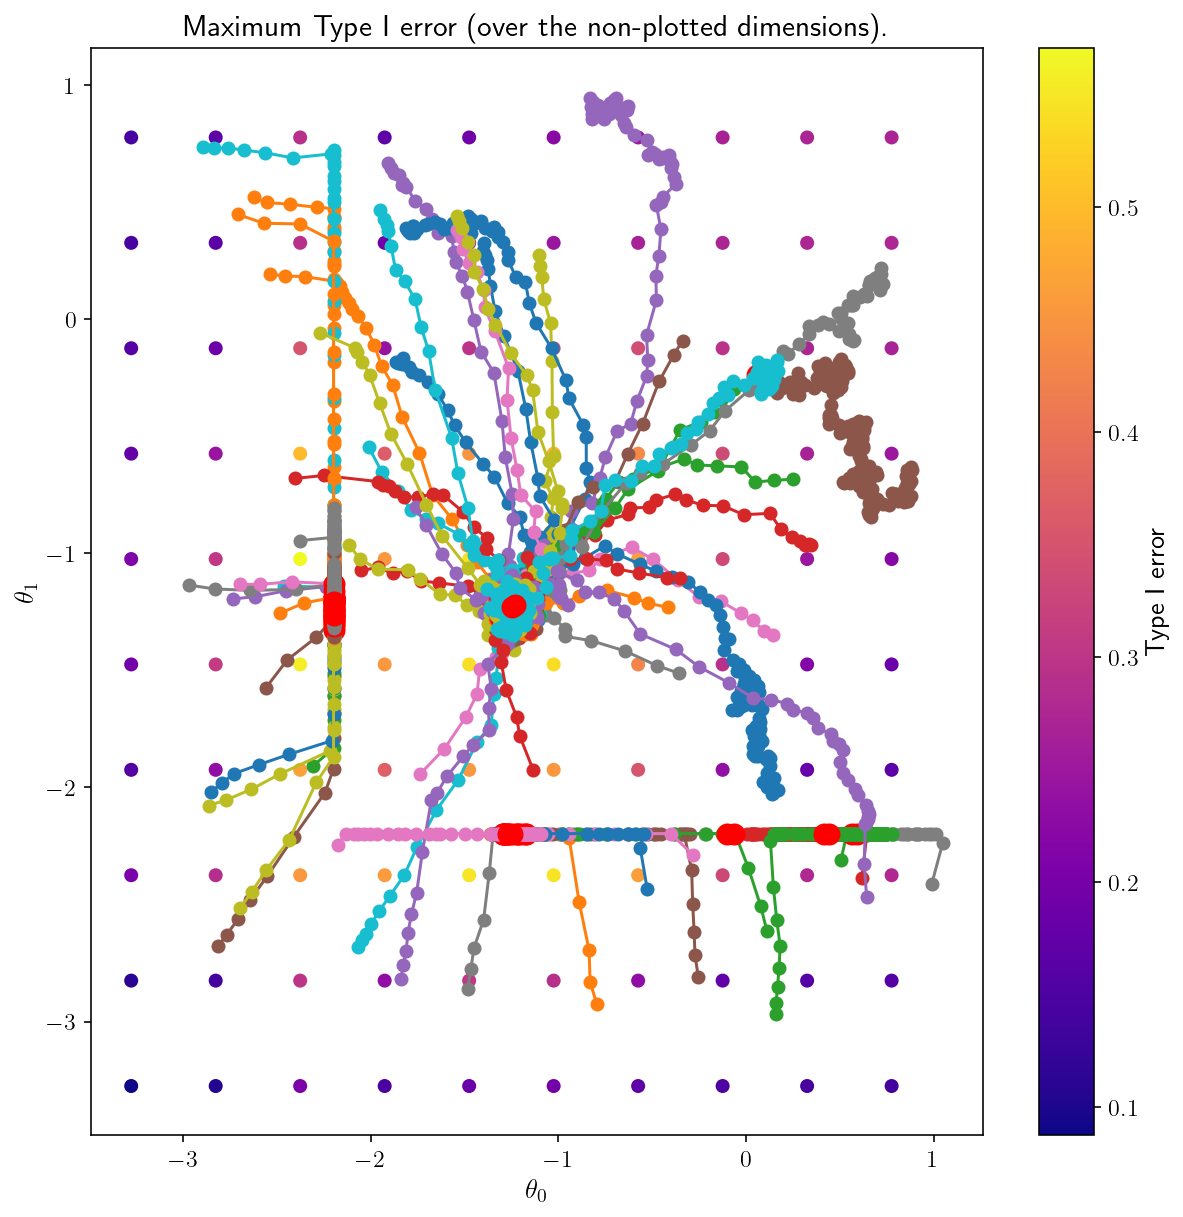

In [24]:
from matplotlib import cm
plt.figure(figsize=(10,10))
plt.title("Type I error at grid points.")
plt.title('Maximum Type I error (over the non-plotted dimensions).')
plt.scatter(uniques[:,0], uniques[:,1], c=unique_max / sim_size)
for i in range(paths.shape[0]):
    plt.plot(paths[i, :, 0], paths[i, :, 1], linestyle="-", marker='o')
    plt.plot(paths[i, -2:, 0], paths[i, -2:, 1], "ro", markersize=10)
cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()


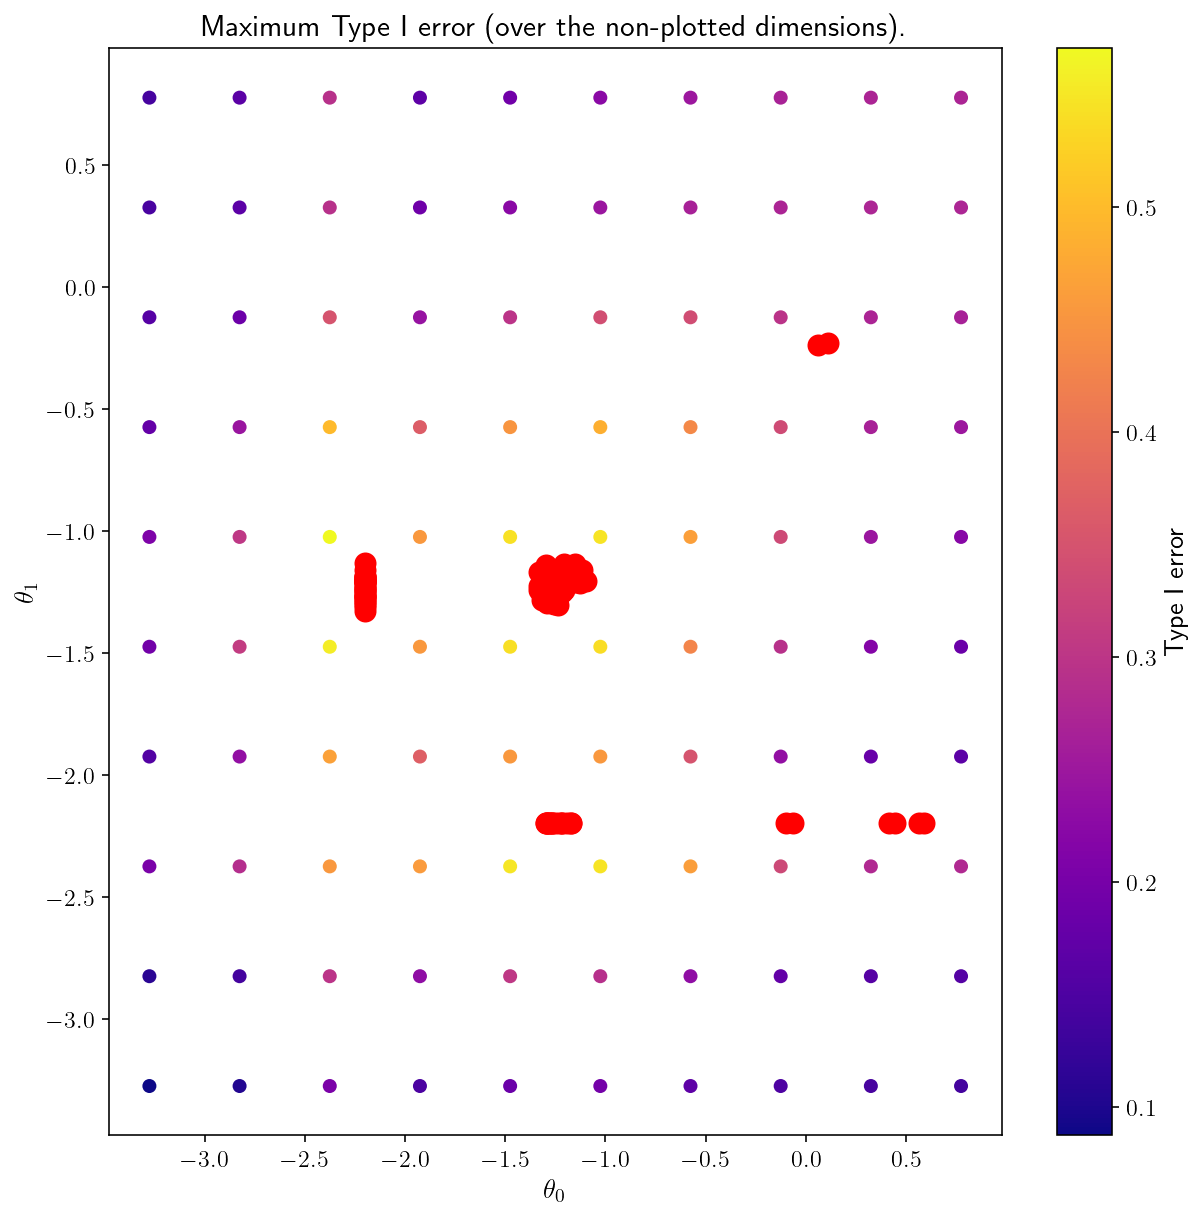

In [25]:
from matplotlib import cm
plt.figure(figsize=(10,10))
plt.title("Type I error at grid points.")
plt.title('Maximum Type I error (over the non-plotted dimensions).')
plt.scatter(uniques[:,0], uniques[:,1], c=unique_max / sim_size)
for i in range(paths.shape[0]):
    plt.plot(paths[i, -2:, 0], paths[i, -2:, 1], "ro", markersize=10)
cbar = plt.colorbar()
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
cbar.set_label('Type I error')
plt.show()
